# Importing ODV aggregated spreadsheet data

* Data are supposed to be aggregated using ODV and exported as aggregated ODV spreadsheet or ODV netCDF files.
* Substitute the file name `small_ODV_sample.txt` with the file name of your aggregated ODV file. 
* Do not export "data error" from ODV (column header `STANDARD_DEV`).

This notebook describes the reading of
1. ODV spreadsheet and 
2. ODV netCDF files.

⚠️ This notebook shows how to read ODV spreadsheet and netCDF files. The latter format is nevertheless preferred, as it allows a faster reading, especially for big files.

In [1]:
using DIVAnd
using CairoMakie
using GeoMakie
using NCDatasets
using Dates
using Statistics
using DelimitedFiles
include("../config.jl")

"https://dox.uliege.be/index.php/s/8tRk0NAStr2P70j/download"

## 1. Read spreadsheet file
Substitute `small_ODV_sample.txt` with the file name of your aggregated ODV file.     
Or you can download the small test file (71 stations).

In [2]:
download_check(smallODVfile, smallODVfileURL)

[ Info: File already downloaded


Aggregated ODV files do not have a semantic header, therefore we need to extract the corresponding column by using the "local" column header name (instead of being able to use the P01 name for the ODV files conforming to 
[Specification of SeaDataNet Data Transport Formats](https://www.seadatanet.org/content/download/636/3333/file/SDN2_D85_WP8_Datafile_formats.pdf?version=2)).


By default only `good` and `probably good` values are loaded.     
This can be changed using the optional parameter `qv_flags`:

In [3]:
DIVAnd.ODVspreadsheet.GOOD_VALUE

"1"

In [4]:
?ODVspreadsheet.load

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `DIVAnd.ODVspreadsheet.load`


```
 obsvalue,obslon,obslat,obsdepth,obstime,obsids = load(T,fnames,datanames;
    qv_flags = [DIVAnd.ODVspreadsheet.GOOD_VALUE,
                DIVAnd.ODVspreadsheet.PROBABLY_GOOD_VALUE],
    nametype = :P01,
    qvlocalname = "QV:SEADATANET")
```

Load all the profiles from every files listed in the array `fnames` corresponding to one of the parameter names `datanames`. If `nametype` is `:P01` (default), the datanames are P01 vocabulary names with the SDN prefix. If nametype is `:localname`, then they are the ODV column header without units.

For example if the column header is `Water body salinity [per mille]`, then `datenames` should be `["Water body salinity"]`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively). Only values matching the quality flag `qv_flags` are retained. `qv_flags` is a vector of Strings (based on http://vocab.nerc.ac.uk/collection/L20/current/, e.g. "1" means "good value"). One can also use the constants these constants (prefixed with `DIVAnd.ODVspreadsheet.`):

`qvlocalname` is the column name to denote quality flags. It is assumed that the quality flags follow immediately the data column.

|                     constant | value |
| ----------------------------:| -----:|
|         `NO_QUALITY_CONTROL` |   "0" |
|                 `GOOD_VALUE` |   "1" |
|        `PROBABLY_GOOD_VALUE` |   "2" |
|         `PROBABLY_BAD_VALUE` |   "3" |
|                  `BAD_VALUE` |   "4" |
|              `CHANGED_VALUE` |   "5" |
|      `VALUE_BELOW_DETECTION` |   "6" |
|            `VALUE_IN_EXCESS` |   "7" |
|         `INTERPOLATED_VALUE` |   "8" |
|              `MISSING_VALUE` |   "9" |
| `VALUE_PHENOMENON_UNCERTAIN` |   "A" |

If the ODV does not contain a semantic header (e.g. for the aggregated ODV files), then local names must be used.

```julia-repl
julia> data,obslon,obslat,obsdepth,obstime,obsids = DIVAnd.ODVspreadsheet.load(Float64,["data_from_med_profiles_non-restricted_v2.txt"],
      ["Water body salinity"]; nametype = :localname );
```

In order to read ODV spreasheet containing World Ocean Database file `odvfile`, one can use a command like:

```julia-repl
julia> obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[odvfile],
                           ["Temperature"]; qv_flags=["0", "1"], nametype = :localname, qvlocalname = "QV:WOD");
```

i.e.,

  * explicitely specifying the accepted flags `qv_flags`
  * set `qvlocalname` as "QV:WOD".

*Note:* no checks are performed to ensure the units are consistent.

---

```
 profiles,lons,lats,depths,times,ids = load(T,dir,P01names)
```

Load all the ODV files under the directory `dir` corresponding the one of the parameter names `P01names`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String`, respectively).

No checks are done to ensure the units are consistent.


If for some reasons, the column name contains an underscore (`Water_body_phosphate` as opposed to `Water body phosphate`), then the local name should also use underscoes.

In [5]:
obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[smallODVfile],
                           ["Water body salinity"]; nametype = :localname );

[ Info: Reading data from file ../data/small_ODV_sample.txt
[ Info: No. of profiles in the file: 71
[ Info: Working on variable Water body salinity
[ Info: Starting loop on the 71 profiles
[ Info: Done reading the profiles


Basic range check for the data (and presence of NaN and Inf)

In [6]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (DateTime("1966-02-13T05:00:00"), DateTime("2016-11-24T10:39:00"))
                          minimum and maximum of data: (37.1775, 39.313)


Individual elements can be retrieved by indexing `obsdata`, `obslat`, `obslon`, `obsdepth` and `obstime`,      
for example:

In [7]:
obsval[10]

38.72

is the measurement (salinity here) of the 10th data point.

### Quick plot
To see the data locations

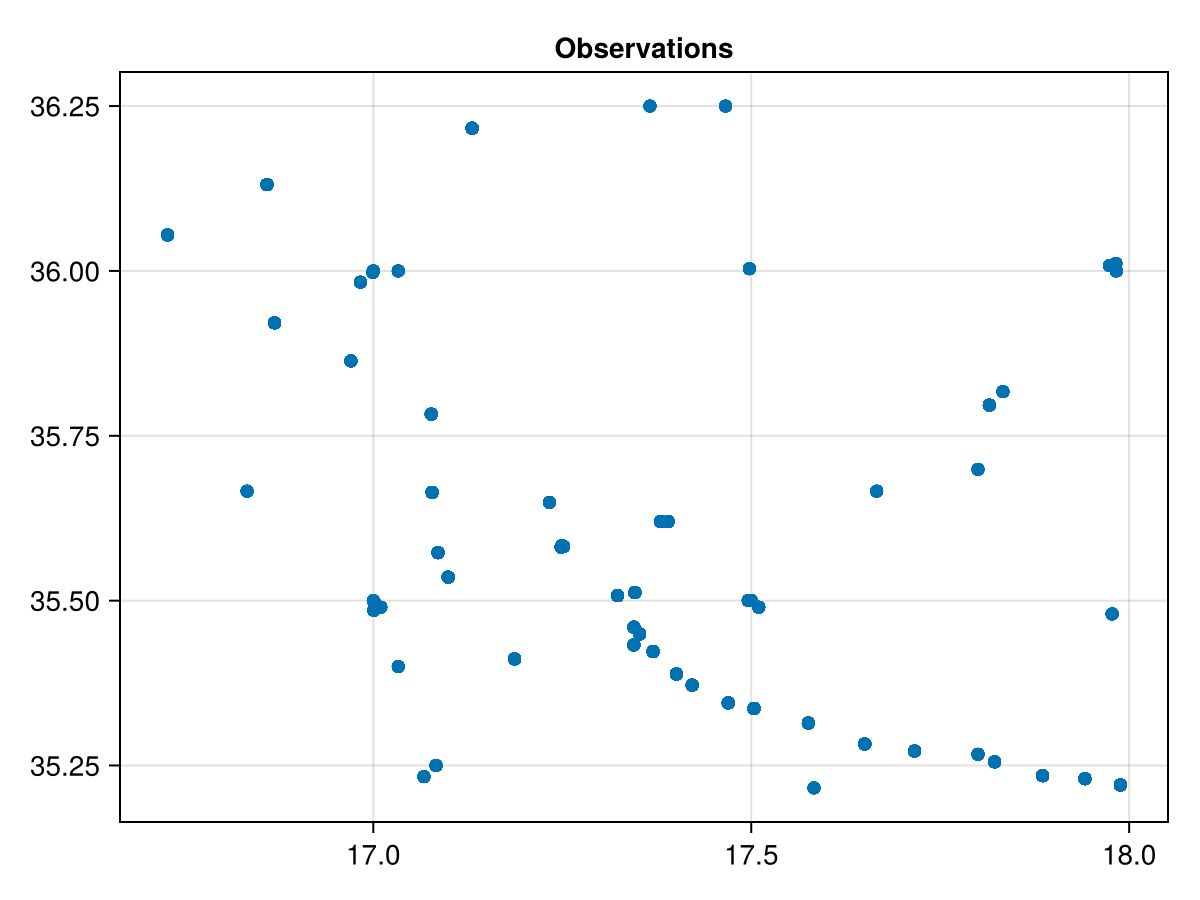

In [8]:
f = CairoMakie.Figure()
ax = Axis(f[1, 1], title = "Observations")
CairoMakie.scatter!(ax, obslon, obslat)
f

### Remove data from the file
Generate a text file to keep track of the removed data.        
Define the indices of the data to delete:

In [9]:
index = [10,14]

2-element Vector{Int64}:
 10
 14

Create an array containing these data:

In [10]:
baddata = ["lon" "lat" "depth" "time" "value" "ids";
    obslon[index]  obslat[index] obsdepth[index] obstime[index] obsval[index] obsid[index]]

3×6 Matrix{Any}:
   "lon"    "lat"      "depth"  …  "ids"
 17.366   36.25     600.0          "681-RNODC_Bottle_10911_123"
 17.366   36.25    1950.0          "681-RNODC_Bottle_10911_123"

The array will be written to a file as a text using the function `writedlm`.

In [11]:
?writedlm

search: writedlm write iswritable readdlm



```
writedlm(f, A, delim='\t'; opts)
```

Write `A` (a vector, matrix, or an iterable collection of iterable rows) as text to `f` (either a filename string or an `IO` stream) using the given delimiter `delim` (which defaults to tab, but can be any printable Julia object, typically a `Char` or `AbstractString`).

For example, two vectors `x` and `y` of the same length can be written as two columns of tab-delimited text to `f` by either `writedlm(f, [x y])` or by `writedlm(f, zip(x, y))`.

# Examples

```jldoctest
julia> using DelimitedFiles

julia> x = [1; 2; 3; 4];

julia> y = [5; 6; 7; 8];

julia> open("delim_file.txt", "w") do io
           writedlm(io, [x y])
       end

julia> readdlm("delim_file.txt", '\t', Int, '\n')
4×2 Matrix{Int64}:
 1  5
 2  6
 3  7
 4  8

julia> rm("delim_file.txt")
```


In [12]:
sel = trues(size(obslon))
sel[index] .= false

obslon_only_good_data = obslon[sel];
obslat_only_good_data = obslat[sel];
obsdepth_only_good_data = obsdepth[sel];
obstime_only_good_data = obstime[sel];
obsdata_only_good_data = obsval[sel];
obsids_only_good_data = obsid[sel];

@show size(obslon_only_good_data);
@show size(obslon);

size(obslon_only_good_data) = (28262,)
size(obslon) = (28264,)


In [13]:
writedlm(joinpath(datadir, "my_bad_data.txt"), baddata)

The identifier is a combination of the EDMO code and LOCAL CDI ID

In [14]:
;cat ../data/my_bad_data.txt

lon	lat	depth	time	value	ids
17.366	36.25	600.0	1977-04-07T02:00:00	38.72	681-RNODC_Bottle_10911_123
17.366	36.25	1950.0	1977-04-07T02:00:00	38.65	681-RNODC_Bottle_10911_123


## Select data according to criterion
For the purpose of the example, let's assume we want to keep only the salinity values below 39.25 (even if the observations are good).

In [15]:
sel = obsval .< 39.25;

index = findall(.!sel)
@info("Number of removed observations: $(length(index))");

obsval_good = obsval[sel]
obslon_good = obslon[sel]
obslat_good = obslat[sel]
obsdepth_good = obsdepth[sel]
obstime_good = obstime[sel]
obsid_good = obsid[sel];

[ Info: Number of removed observations: 9


In [16]:
checkobs((obslon_good,obslat_good,obsdepth_good,obstime_good),obsval_good,obsid_good)

              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (DateTime("1966-02-13T05:00:00"), DateTime("2016-11-24T10:39:00"))
                          minimum and maximum of data: (37.1775, 39.212)


[ Info: Checking ranges for dimensions and observations


Here we use a criterion based on the depth and on the time of measurement (month):

In [17]:
sel = (obsdepth .< 50.) .& (Dates.month.(obstime) .== 10)
@show sum(sel);
@show length(obsval);
obsval_new = obsval[sel];

sum(sel) = 129
length(obsval) = 28264


Let's create a histogram showing the number of observations per month:

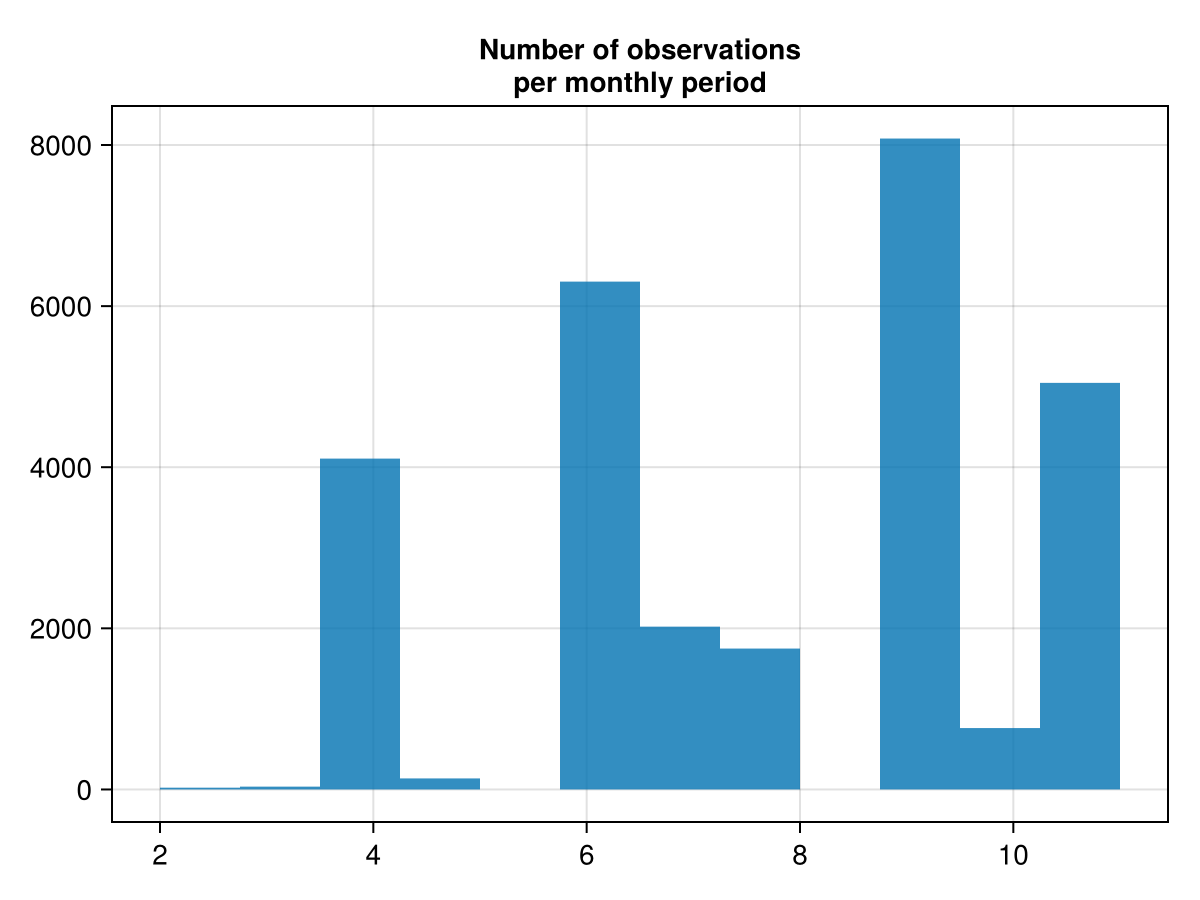

In [18]:
f = CairoMakie.Figure()
ax = CairoMakie.Axis(f[1,1], title="Number of observations\nper monthly period")
CairoMakie.hist!(ax, Dates.month.(obstime), bins = 12)
f

### Plot the selected data positions

In [19]:
bathname = gebco16file
download_check(gebco16file, gebco16fileURL)
bathisglobal = true

# Extract the bathymetry for plotting
lonr = extrema(obslon[sel])
latr = extrema(obslat[sel])

lonr = -10.:30.
latr = 30.:45.
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

[ Info: File already downloaded


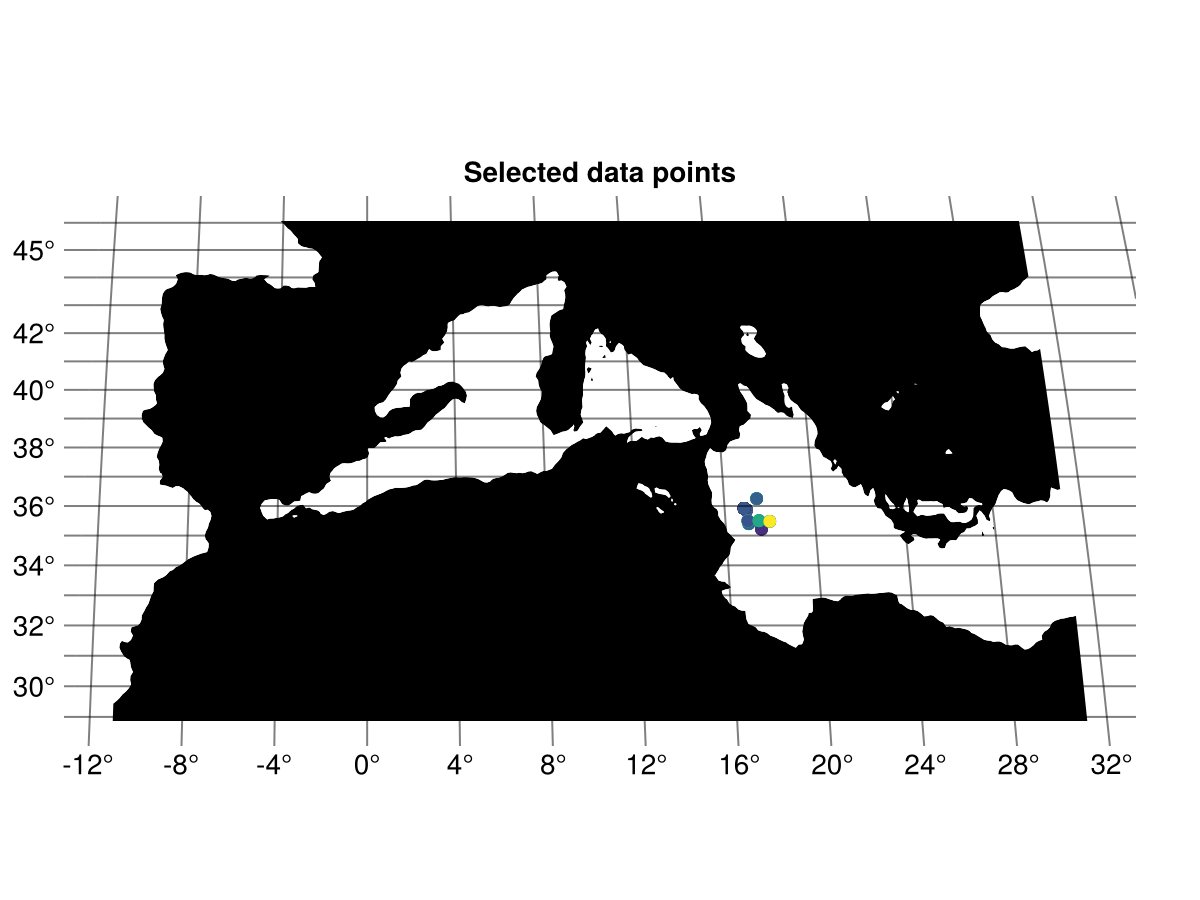

In [20]:
f = GeoMakie.Figure()
ax = GeoAxis(f[1,1], title="Selected data points")
GeoMakie.contourf!(ax, bx, by, b, levels = 2, colormap=Reverse("binary"))
GeoMakie.scatter!(ax, obslon[sel],obslat[sel]; color = obsval[sel])
f

## 2. Read ODV netCDF
Download the file or use one of your file.

In [21]:
download_check(smallODVncfile, smallODVncfileURL)

[ Info: File already downloaded


The function `NCODV.load` is designed to read netCDF files generated by ODV. In addition it has been optimised so large files (a few GB) can be ingested in a few minutes.

In [22]:
@time obsval2, obslon2, obslat2, obsdepth2, obstime2, obsid2 = NCODV.load(Float64, smallODVncfile, "Water body salinity");

  4.216083 seconds (13.08 M allocations: 714.502 MiB, 4.56% gc time, 99.27% compilation time)


A quick plot helps to check if we obtain the same data as with the spreadsheet (1st figure of the notebook):

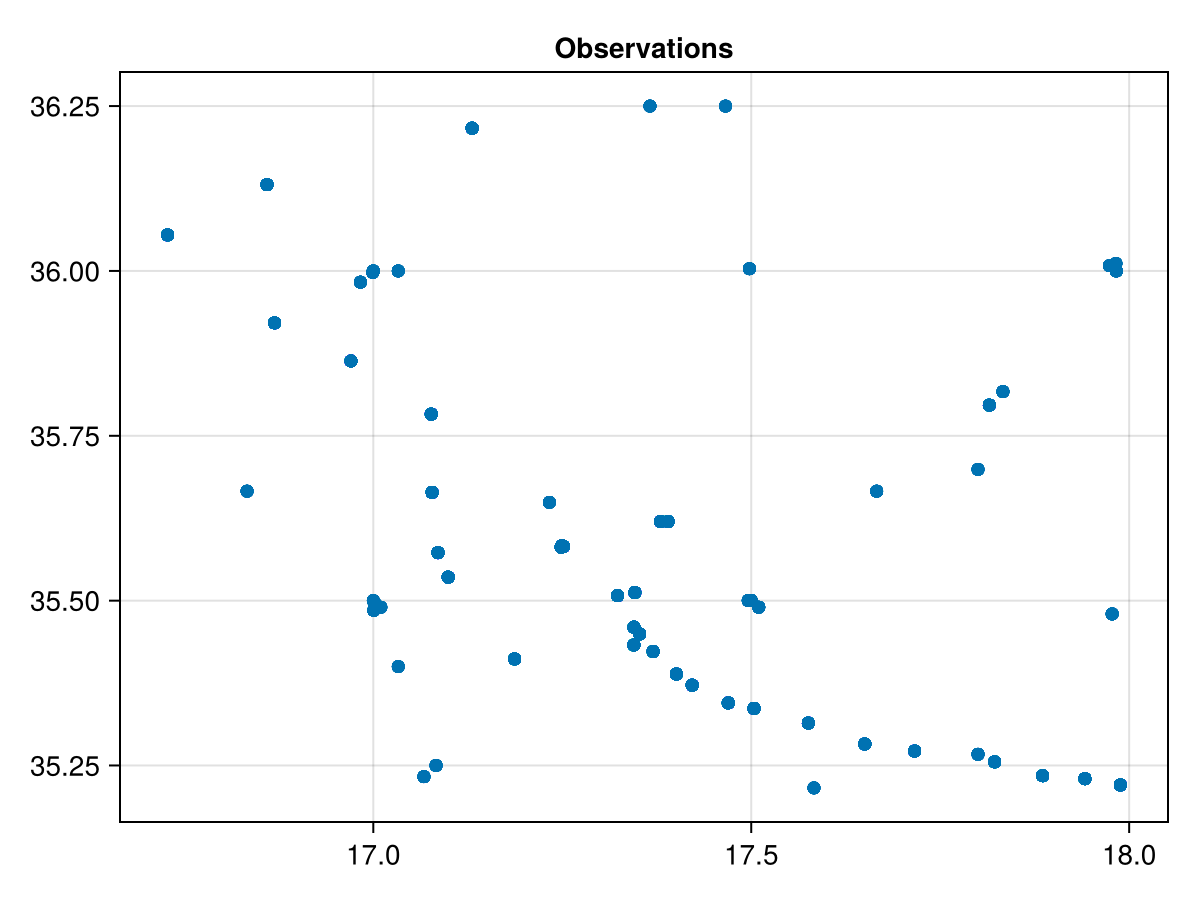

In [23]:
f = CairoMakie.Figure()
ax = Axis(f[1, 1], title = "Observations")
CairoMakie.scatter!(ax, obslon2, obslat2)
f

**⚠️ Note**: when you expect to have to read several times a large netCDF file, it is convenient to save it in a simplified form, easier and faster to read than the ODV netCDF file.           
This can be done using the function `saveobs`:

In [24]:
datafile3 = joinpath(datadir, "small_ODV_sample_simple.nc")
isfile(datafile3) ? rm(datafile3) : @debug("ok")
DIVAnd.saveobs(datafile3, "salinity", obsval2, (obslon2, obslat2, obsdepth2, obstime2),obsid2)

That file can then be read using the function `loadobs`.

In [25]:
@time obsval3, obslon3, obslat3, obsdepth3, obstime3, obsids3 = loadobs(Float64, datafile3, "salinity");

  0.578883 seconds (1.99 M allocations: 136.486 MiB, 96.54% compilation time)
